# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import pystan
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import acf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [2]:
data_2019 = pd.read_csv(r'C:\Users\manub\Documents\Datasets\flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(r'C:\Users\manub\Documents\Datasets\flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(r'C:\Users\manub\Documents\Datasets\flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#dataset.head()

In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#dataset.head()

In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#dataset.head()

In [13]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
#dataset

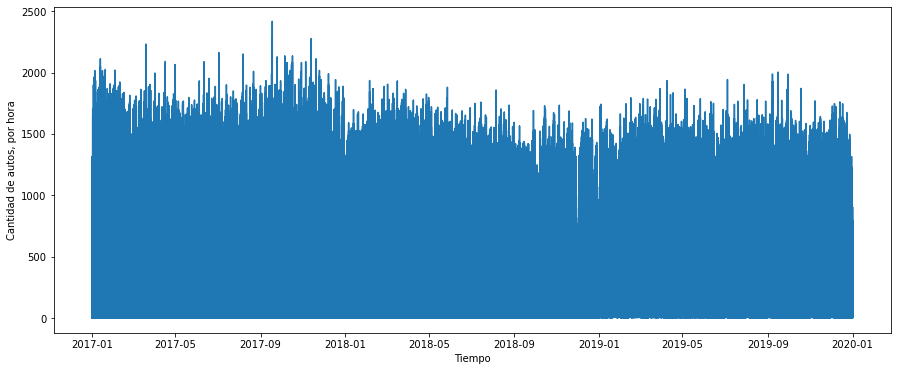

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [15]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
#diario.head()

(1095, 1)


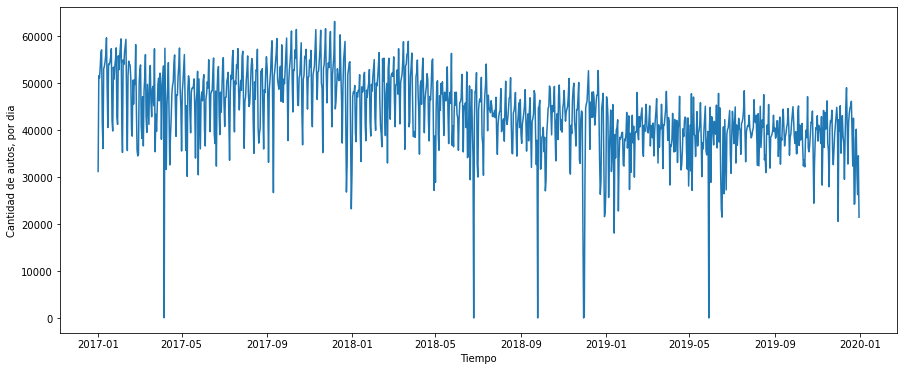

In [16]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

### AED

In [17]:
# cambiamos el nombre solo por comodidad
df = dataset.copy()
del dataset

datasets:
- df (contiene toda la info, hasta discriminada por hora)
- diario

OUTLIERS

In [18]:
diario[diario.cantidad_pasos < 15000]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Paros:
- 06/04/17
- 25/06/18
- 25/09/18
- 29/05/19

G20:
- 30/11/18
- 01/12/18

Voy a imputar el paso promedio segun el dia de la semana al que corresponde el valor extremo

In [19]:
diario.reset_index(drop = False, inplace = True)
diario.head()

,fecha,cantidad_pasos
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486


In [20]:
diario['dia'] = diario['fecha'].dt.dayofweek

In [21]:
def conversor_dia(dia):
    if dia == 0:
        return 'lunes'
    if dia == 1:
        return 'martes'
    if dia == 2:
        return 'miercoles'
    if dia == 3:
        return 'jueves'
    if dia == 4:
        return 'viernes'
    if dia == 5:
        return 'sabado'
    if dia == 6:
        return 'domingo'
diario['dia'] = diario['dia'].apply(lambda dia: conversor_dia(dia))
diario.head()

,fecha,cantidad_pasos,dia
0,2017-01-01,31183,domingo
1,2017-01-02,51568,lunes
2,2017-01-03,51093,martes
3,2017-01-04,53332,miercoles
4,2017-01-05,56486,jueves


In [22]:
promedio_por_dia = (diario.groupby(by = 'dia').mean()).round()
promedio_por_dia

,cantidad_pasos
dia,
domingo,36891.0
jueves,46809.0
lunes,42620.0
martes,43730.0
miercoles,45676.0
sabado,41293.0
viernes,49021.0


Observacion importante:

Se puede observar claramente como los fines de semana hay una menor circulacion (principalmente el domingo que se corresponde como el dia de descanso de la mayoria de las profesiones).

Y es particular observar como a medida que avanzamos en la semana se incrementa la circulacion vehicular

In [23]:
outliers = diario[diario.cantidad_pasos < 15000]
outliers

,fecha,cantidad_pasos,dia
95,2017-04-06,40,jueves
540,2018-06-25,0,lunes
632,2018-09-25,0,martes
698,2018-11-30,0,viernes
699,2018-12-01,350,sabado
878,2019-05-29,0,miercoles


In [24]:
# Agrego columna promedio_por_dia para poder hacer el for
outliers = pd.merge(outliers, promedio_por_dia, how = 'left', left_on = 'dia', right_index = True)
outliers.rename(columns = {'cantidad_pasos_y':'promedio_por_dia'}, inplace = True)
outliers

,fecha,cantidad_pasos_x,dia,promedio_por_dia
95,2017-04-06,40,jueves,46809.0
540,2018-06-25,0,lunes,42620.0
632,2018-09-25,0,martes,43730.0
698,2018-11-30,0,viernes,49021.0
699,2018-12-01,350,sabado,41293.0
878,2019-05-29,0,miercoles,45676.0


In [25]:
for x in outliers['fecha']:    
    diario['cantidad_pasos'].values[diario['fecha'] == x] = outliers[outliers['fecha'] == x]['promedio_por_dia']

print((diario.cantidad_pasos < 15000).sum())  

0


NULLS

In [26]:
pd.isna(df).sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

No hay nulos, por lo tanto no se realizan ajustes

Pasamos a semanal

In [27]:
semanal = diario.resample(rule = "W", on = 'fecha').sum()

# eliminamos primera y ultima fila (es un dia, no una semana)
semanal.drop(index = [semanal.index[0],semanal.index[157]], inplace = True)
semanal.head()

,cantidad_pasos
fecha,
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581
2017-02-05,359401


In [28]:
tendencia_semanal = semanal['cantidad_pasos'].rolling(window = 4, center = True).mean()
tendencia_semanal = pd.DataFrame(tendencia_semanal)
tendencia_semanal.head()

,cantidad_pasos
fecha,
2017-01-08,NaN
2017-01-15,NaN
2017-01-22,356355.25
2017-01-29,359402.50
2017-02-05,358742.75


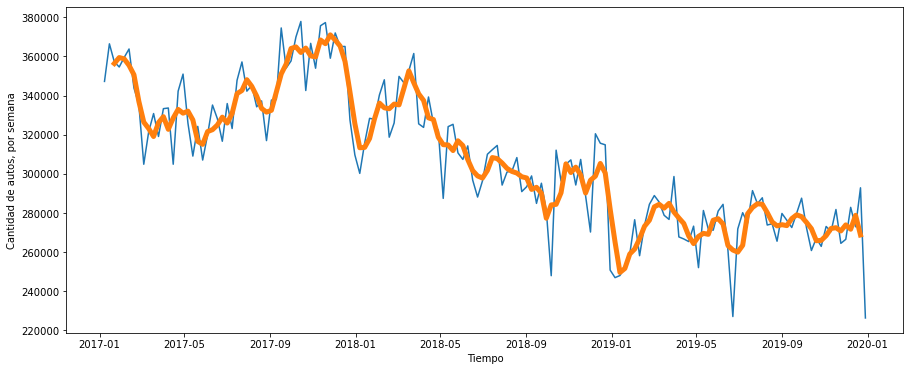

In [29]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.plot(tendencia_semanal.index, tendencia_semanal.cantidad_pasos, lw = 5)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

La tendencia es negativa, pero recordemos que estamos analizando solamente los abonados en efectivo, esto podria ser ocasionado porque la gente esta adoptando otros metodos de pagos alternativos.

Aunque seria logico pensar, que la tendencia tambien podria deberse a dos motivos:

1- Teroicamente, en Argentina, es muy probable que el factor inflacionario no se transfiera al transporte publico en la misma proporcion en que lo hace con el precio de la nafta, seguros, etc. Por lo tanto, se podria tomar como insight que la gente comienza a adoptar medios alternativos de transporte.

2- Por otro lado, por los avances tecnologicos logicamente el precio de los autos disminuye, haciendo que la sociedad pueda hacerse de cada vez mas automoviles, haciendo incrementar la cantidad en circulacion, generando un exceso de demanda para los peajes, incrementando el precio de los mismos y de esta manera haciendo que las personas busquen disminuir su consumo, ya sea utilizando caminos o transportes alternativos, o simplemente hacer uso de carpool (vehiculo compartido, tendencia que esta ganando popularidad en el pais y el mundo).

Interesante, como a simple vista se puede observar que en Febrero disminuye claramente el consumo (suele ser la epoca en la que las mayorias de los rubros laborales se encuentran en vacaciones o descanso). Por lo tanto buscare profundizar mi analisis comparando el flujo vehicular entre los meses

In [30]:
mensual = diario.resample(rule = 'M', on = 'fecha').sum()

mensual.reset_index(drop = False, inplace = True)

mensual['mes'] = mensual.fecha.dt.month
mensual.head()

,fecha,cantidad_pasos,mes
0,2017-01-31,1565260,1
1,2017-02-28,1363113,2
2,2017-03-31,1451214,3
3,2017-04-30,1420754,4
4,2017-05-31,1407136,5


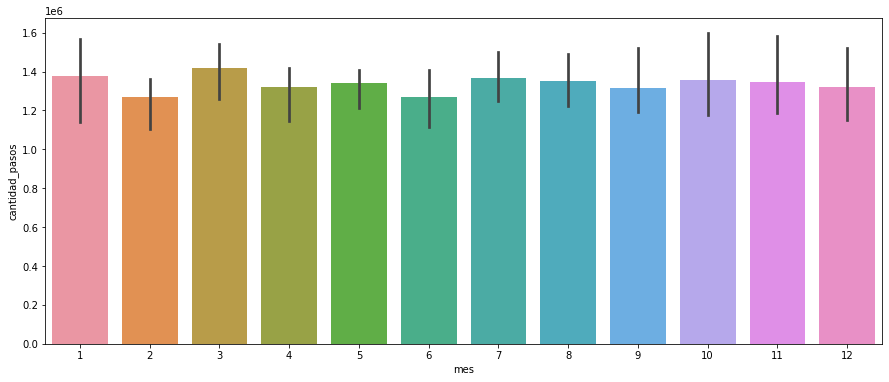

In [31]:
plt.figure(figsize = (15,6))

sns.barplot(x = 'mes', y = 'cantidad_pasos', data = mensual)

plt.show()

A la conclusion recien obtenida, le agregamos que junio tambien es un mes en el que disminuye la circulacion (ademas de las vacaciones escolar de invierno), es una epoca en la que mucha gente opta por utilizar sus licencias por descanso

Voy a analizar ahora la circulacion por hora

In [32]:
df['año'] = df.fecha.dt.year
df['mes'] = df.fecha.dt.month
df['numero_dia'] = df.fecha.dt.day
df['hora'] = df.fecha.dt.hour

df.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha,año,mes,numero_dia,hora
0,Domingo,Provincia,Pesado,1,2017-01-01,2017,1,1,0
1,Domingo,Provincia,Liviano,9,2017-01-01,2017,1,1,0
2,Domingo,Provincia,Liviano,644,2017-01-01,2017,1,1,0
3,Domingo,Provincia,Pesado,6,2017-01-01,2017,1,1,0
4,Domingo,Provincia,Pesado,1,2017-01-01,2017,1,1,0


In [33]:
hora = (df[['cantidad_pasos','hora']].groupby(by = 'hora').mean()).round()
hora.head()

,cantidad_pasos
hora,
0,114.0
1,99.0
2,71.0
3,52.0
4,41.0


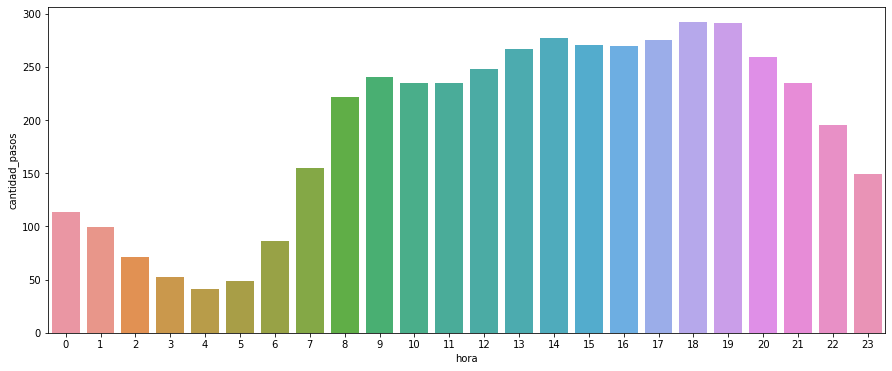

In [34]:
plt.figure(figsize = (15,6))

sns.barplot(x = hora.index ,y = 'cantidad_pasos', data = hora)

plt.show()

Al analizar la circulacion se puede observar la disminucion a partir del anochecer, y los picos en las horas asociadas a la jornada laboral cotidiana (de 9 a 18 hs).

Vamos a discriminar por tipo de vehiculo

In [35]:
hora_tipo_vehiculo = df.groupby(by = ['hora','tipo_vehiculo']).mean()
hora_tipo_vehiculo.reset_index(drop = False, inplace = True)
hora_tipo_vehiculo.head()

,hora,tipo_vehiculo,cantidad_pasos,año,mes,numero_dia
0,0,Liviano,284.480541,2017.798234,6.503174,15.656914
1,0,Pesado,4.697906,2017.670217,6.387469,15.689918
2,1,Liviano,237.444506,2017.798002,6.507214,15.730577
3,1,Pesado,4.424541,2017.701004,6.441015,15.719561
4,2,Liviano,164.521703,2017.799558,6.512303,15.733204


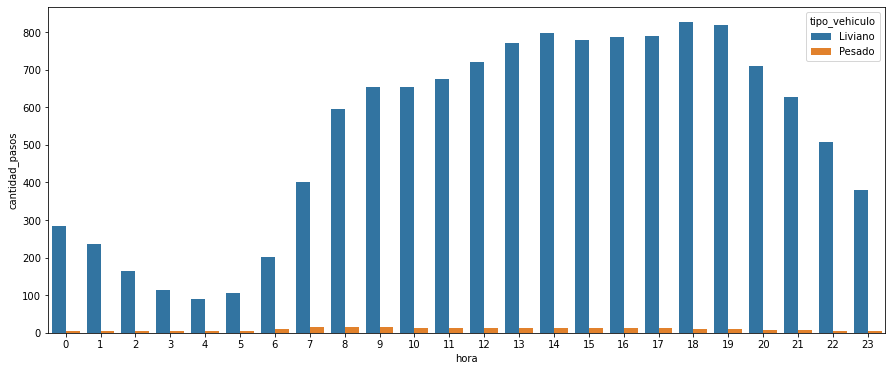

In [36]:
plt.figure(figsize = (15,6))

sns.barplot(x = 'hora' , y = 'cantidad_pasos', data = hora_tipo_vehiculo, hue = 'tipo_vehiculo')

plt.show()

Al analizarlas de manera comparativa, no se obtienen grandes resultados ya que la visual se ve afectada por la gran cantidad de transito liviano en comparacion al pesado. Por lo que se analizara la circulacion del transito pesado por separado. Sin embargo, se puede notar como poseen distintos patrones en el horario de circulacion (camiones pesado, de 6 a 19, esta ligado a los horarios en los que funcionan las construcciones)

In [37]:
hora_pesado = df[df.tipo_vehiculo == 'Pesado']
hora_pesado = hora_pesado.groupby(by = 'hora').mean()
print(hora_pesado.head())

hora_liviano = df[df.tipo_vehiculo == 'Liviano']
hora_liviano = hora_liviano.groupby(by = 'hora').mean()
print(hora_liviano.head())

      cantidad_pasos          año       mes  numero_dia
hora                                                   
0           4.697906  2017.670217  6.387469   15.689918
1           4.424541  2017.701004  6.441015   15.719561
2           3.876663  2017.707646  6.416882   15.815293
3           3.723570  2017.719139  6.388268   15.777379
4           3.975187  2017.732406  6.391658   15.834225
      cantidad_pasos          año       mes  numero_dia
hora                                                   
0         284.480541  2017.798234  6.503174   15.656914
1         237.444506  2017.798002  6.507214   15.730577
2         164.521703  2017.799558  6.512303   15.733204
3         115.089894  2017.802066  6.520380   15.695980
4          88.667227  2017.804317  6.500421   15.691337


LIVIANO

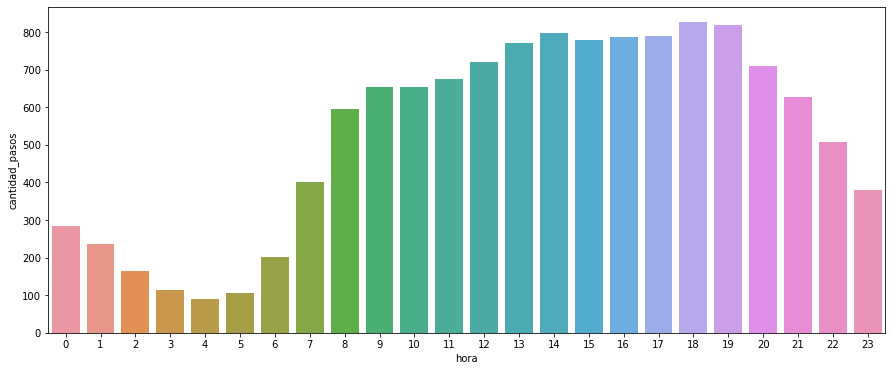

In [38]:
plt.figure(figsize = (15,6))

sns.barplot(x = hora_liviano.index, y = 'cantidad_pasos', data = hora_liviano)

plt.show()

PESADO

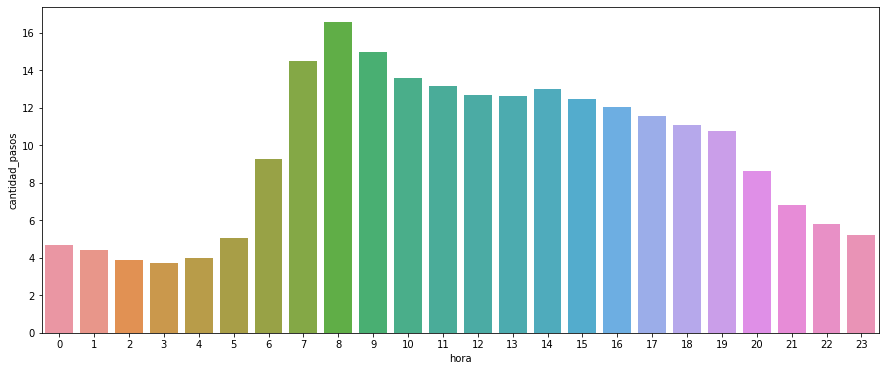

In [39]:
plt.figure(figsize = (15,6))

sns.barplot(x = hora_pesado.index, y = 'cantidad_pasos', data = hora_pesado)

plt.show()

Se reafirma la teoria que indica que hay una gran diferencia entre los tipo de vehiculos, pero no se si se puede asociar a que el movimiento del transito pesado esta ligado solamente a la construccion como se planteo como hipotesis en un momento, sino que se ve que se podria asociar mas a la rama de transporte (por ejemplo camiones que llevan de mercaderias), ya que hay mas circulacion nocturna que la esperada

Se hara el mismo analisis discriminando por sentido 

In [40]:
hora_sentido = df.groupby(by = ['hora','sentido']).mean()
hora_sentido.reset_index(drop = False, inplace = True)
hora_sentido.head()

,hora,sentido,cantidad_pasos,año,mes,numero_dia
0,0,Centro,106.431508,2017.695502,6.348463,15.612050
1,0,Provincia,122.984116,2017.748389,6.528085,15.750460
2,1,Centro,86.255008,2017.708890,6.393990,15.705134
3,1,Provincia,113.799658,2017.777181,6.554361,15.746152
4,2,Centro,62.548056,2017.717428,6.390218,15.837035


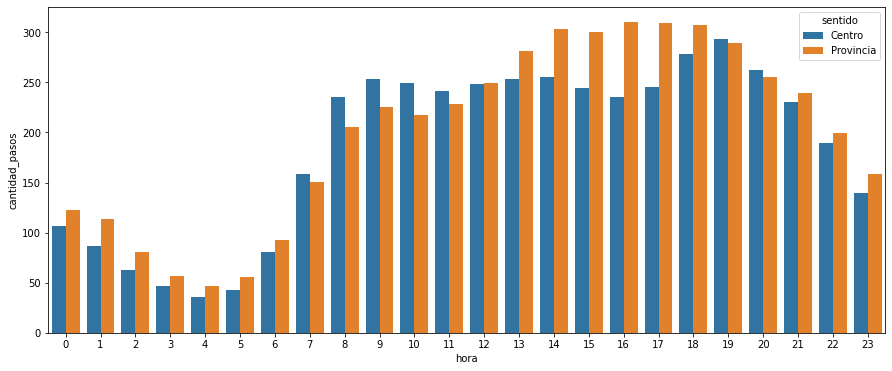

In [41]:
plt.figure(figsize = (15,6))

sns.barplot(x = 'hora' , y = 'cantidad_pasos', data = hora_sentido, hue = 'sentido')

plt.show()

La visual no se ve dificultada para anlizarlas de manera conjunta. Incluso se puede apreciar como los picos con sentido a la provincia se dan a las 17 horas que implicaria el horario en que los habitantes de Provincia se vuelven a sus hogares despues de una jornada laboral

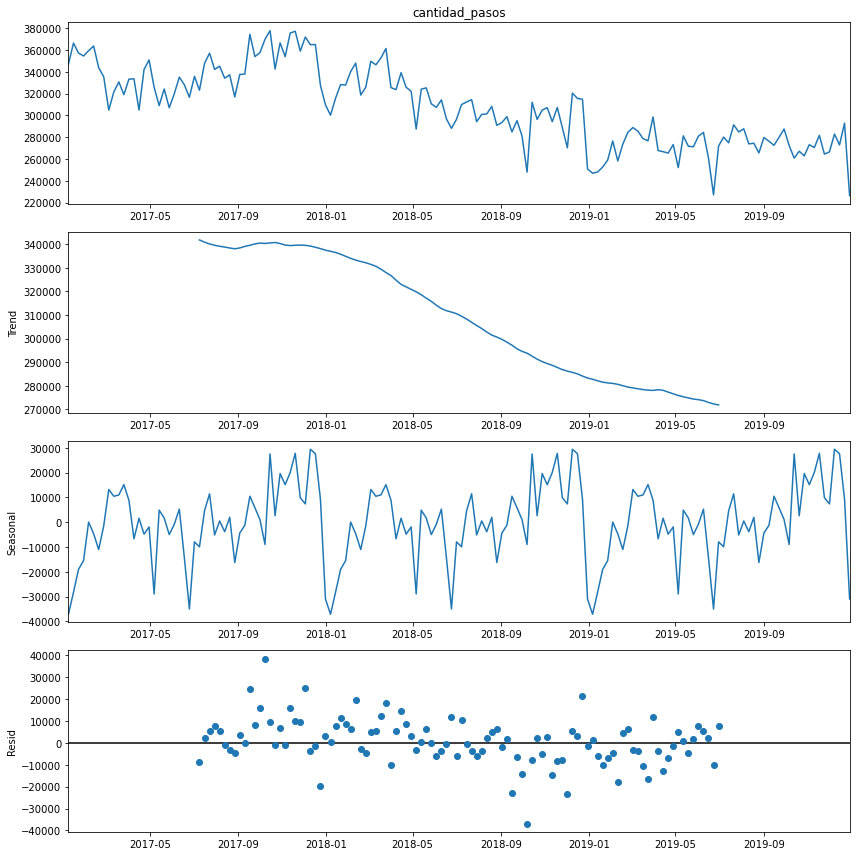

In [42]:
result = seasonal_decompose(semanal.cantidad_pasos, model='additive')

matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

- Ya se explicaron previamente los motivos (supuestos) de porque la tendencia podria ser negativa.
- Gracias a la estacionalidad de los flujos se puede ovservar grandes similitudes en la curva que se repiten 3 veces (son los 3 años, siendo equivalentes los flujos dentro de cada uno de sus meses).
- En el ultimo grafico se nota que son pocos los valores atipicos (ya se les atribuyo los motivos previamente) 

Autocorrelacion

In [43]:
nlags = 30
autocorr = acf(diario.cantidad_pasos, nlags = nlags, fft=False)

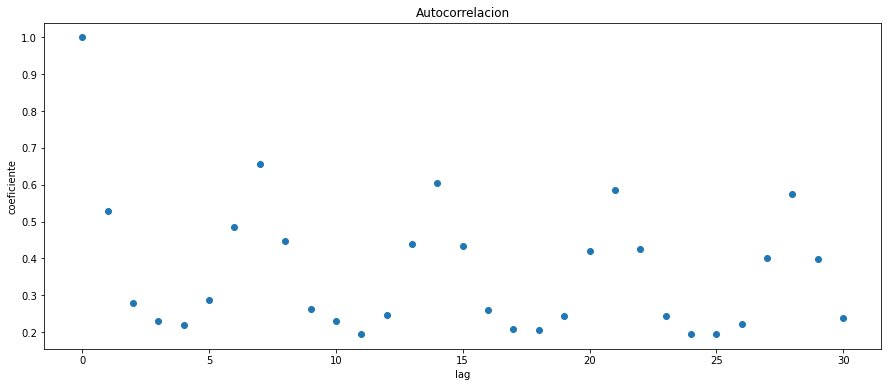

In [44]:
plt.figure(figsize = (15,6))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.ylabel('coeficiente')
plt.title('Autocorrelacion')
plt.show()

Al analizar la autocorrelacion, con un lag de 30 (30 dias corresponden a un mes), se puede observar como hay 4 picos. Esto se debe a que al haber 4 semanas, hay 4 dias de cada uno en un mes. Estando logicamente correlacionados entre si, reafirmando los insights anteriores.

### Modelo predictivo

In [45]:
diario['fecha_numeros'] = diario.fecha.map(datetime.datetime.toordinal)
diario.head()

,fecha,cantidad_pasos,dia,fecha_numeros
0,2017-01-01,31183,domingo,736330
1,2017-01-02,51568,lunes,736331
2,2017-01-03,51093,martes,736332
3,2017-01-04,53332,miercoles,736333
4,2017-01-05,56486,jueves,736334


El modelo es para predecir el ultimo trimestre de 2019, por lo tanto se fija el split para el 30-09-2019

In [46]:
split = '2019-09-30'
train = diario[diario.fecha <= split]
test = diario[diario.fecha > split]

X_train = train[['fecha_numeros']]
y_train = train[['cantidad_pasos']]

X_test = test[['fecha_numeros']]
y_test = test[['cantidad_pasos']]

In [47]:
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)

LinearRegression()

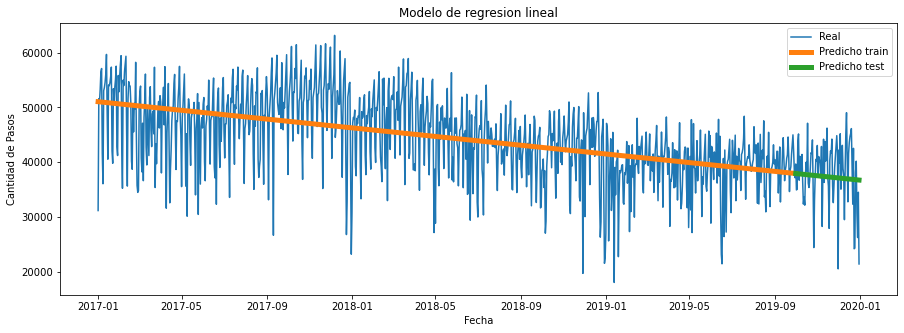

In [48]:
plt.figure(figsize = (15,5))

plt.plot(diario.fecha, diario.cantidad_pasos, label = 'Real')
plt.plot(train.fecha, reg_lin.predict(X_train), label = 'Predicho train', lw = '5')
plt.plot(test.fecha, reg_lin.predict(X_test), label = 'Predicho test', lw = '5')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.title('Modelo de regresion lineal')
plt.legend()
plt.show()

A simple vista, se puede observar que el error de prediccion seria muy grande. Aunque fue muy util hacer dicha representancion ya que enfatiza en la negatividad de la tendencia

In [49]:
y_pred = reg_lin.predict(X_test)

rmse_lineal = np.sqrt(mean_squared_error(y_test, y_pred)).round()
rmse_lineal

5804.0

Vamos a probar con la liberia para series de tiempo Prophet

In [50]:
# Hay que renombrar los df
train = train[['fecha','cantidad_pasos']]
train.rename(columns = {'fecha':'ds','cantidad_pasos':'y'}, inplace = True)

test = test[['fecha','cantidad_pasos']]
test.rename(columns = {'fecha':'ds','cantidad_pasos':'y'}, inplace = True)

In [51]:
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(train)

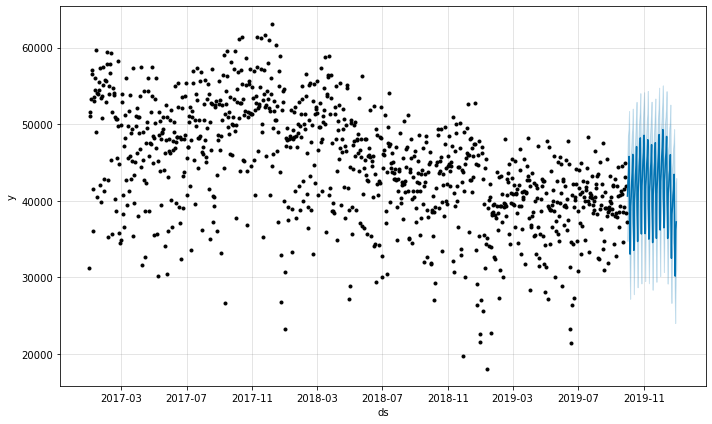

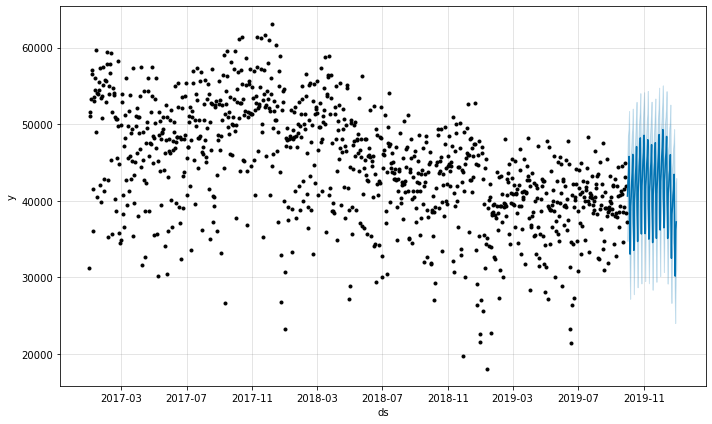

In [52]:
prediccion = modelo_prophet.predict(test)
modelo_prophet.plot(prediccion)

In [53]:
rmse_prop = np.sqrt(mean_squared_error(test.y, prediccion.yhat)).round()
rmse_prop

6165.0

Es inaceptable que el desempeño del modelo sea peor que el modelo de benchmark (regresion lineal), es por ello, que se aplicara una optimizacion de hiperparametros implementada de manera manual

In [54]:
param_grid = [{'growth': 'linear', 'changepoint_prior_scale': 0.03, 'daily_seasonality' : True},
              {'growth': 'linear', 'changepoint_prior_scale': 0.05, 'daily_seasonality' : True},
              {'growth': 'linear', 'changepoint_prior_scale': 0.07, 'daily_seasonality' : True}]

In [55]:
for param in param_grid:
    modelo_prophet = Prophet(**param)
    modelo_prophet.fit(train)
    
    prediccion = modelo_prophet.predict(test)
    
    rmse_prop = np.sqrt(mean_squared_error(test.y, prediccion.yhat)).round()
    parametro = param['changepoint_prior_scale']
    print(('Iteracion con {} --> {}').format(parametro,rmse_prop))

Iteracion con 0.03 --> 5708.0
Iteracion con 0.05 --> 6165.0
Iteracion con 0.07 --> 6455.0


Al menos se logro disminuir un poco el RMSE, quedando este por debajo del correspondiente al modelo de regresion lineal. 

Sin embargo, se tratara de mejorar la prediccion utilizando la tecnica de One-Step Prediction, que consiste, basicamente, en predecir el valor correspondientes a un momento en particular en base a una fraccion de tiempo, previa a dicho valor.

In [56]:
cantidad_pasos = diario.cantidad_pasos
look_back = 30 # usamos 1 mes de datos para predecir el valor siguiente

In [57]:
N = cantidad_pasos.shape[0]    
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

# Lleno con los respectivos valores
for i in range(X.shape[0]):
    X[i,:] = cantidad_pasos.iloc[i:i+look_back]
    y[i] = cantidad_pasos.iloc[i+look_back]
    
print(X.shape, y.shape)

(1064, 30) (1064,)


In [58]:
# Separo en train y test
# En la posicion 972 se encuentra el dia 30/09/2019

X_train = X[:972,:]
y_train = y[:972]
print(X_train.shape, y_train.shape)

X_test = X[972:,:]
y_test = y[972:]
print(X_test.shape, y_test.shape)

(972, 30) (972,)
(92, 30) (92,)


In [59]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4)
random_forest.fit(X_train, y_train)

RandomForestRegressor(n_jobs=4, random_state=42)

In [60]:
y_test_pred = random_forest.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()
rmse

4958.0

Disminuyo mucho el RMSE de test, se optimizaran hiperparametros

In [61]:
random_forest = RandomForestRegressor()

param_dist = {'n_estimators': [50, 100, 200],
             'max_features': np.arange(2,7),
             'n_jobs' : np.arange(3,6)}

model_random = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                  n_iter = 30, random_state = 42, cv=5)

model_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'max_features': array([2, 3, 4, 5, 6]),
                                        'n_estimators': [50, 100, 200],
                                        'n_jobs': array([3, 4, 5])},
                   random_state=42)

In [62]:
print("Mejores parametros: "+str(model_random.best_params_))

Mejores parametros: {'n_jobs': 3, 'n_estimators': 200, 'max_features': 5}


In [63]:
y_train_pred = model_random.predict(X_train)
y_test_pred = model_random.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round()
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()

print('RMSE de train es: ', RMSE_train)
print('RMSE de test es: ', RMSE_test)

RMSE de train es:  1766.0
RMSE de test es:  5109.0


Luego de aplicar Random Search, resulta que los parametros elegidos a priori (n_estimators=100, random_state=42, n_jobs = 4) fueron una buena eleccion

Graficamos

In [64]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
length_total = N_train + N_test + look_back

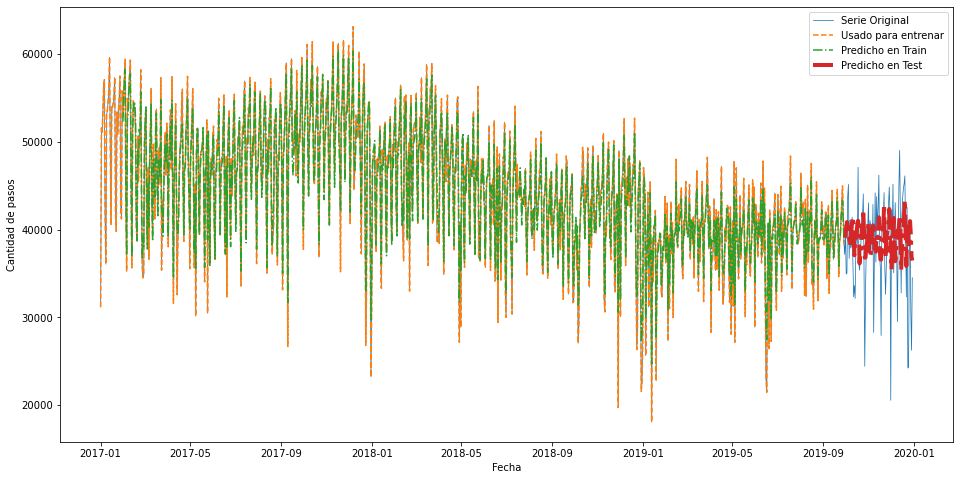

In [65]:
plt.figure(figsize=(16,8))

plt.plot(diario.fecha[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.fecha[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.fecha[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.fecha[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()

Deposite muchas esperanzas en la eficacia del modelo creado con Prophet el cual no resulto y predomino claramente el modelo de random forest, el cual permitio tener un RMSE bastante mas bajo que el benchmark y al hacer una representacion grafica comparando los valores reales con los predichos (en test y train), considero que posee un desempeño aceptable.

Personalmente, no le encuentro sentido en aplicar el modelo creado al año 2020. Considero que no agrega valor, ya que a partir de marzo de 2020 comenzo la pandemia que limito la circulacion en todo el pais, haciendo que las predicciones esten totalmente desfasadas con la realidad.

Para el modelo de RF con la tecnica de one-step, simplemente se podrian incorporar los campos tipo de vehiculo, forma de pago, sentido, dia de la semana.

A simple vista, dudo que mejore el modelo, porque:
- Dia de semana: informacion implicita en la composicion del X_train por un lag > 7.
- Tipo de vehiculo: Si bien hay mucha diferencia entre (liviano y pesado), ambos no tienen patrones muy distintos para su proporcion por dia, por lo que agregaria informacion no relevante al modelo.
- forma de pago: No agregaria valor incorporar un campo que tenga la forma de pago, lo que si mejoraria trabajar con todas las formas de pago.
- sentido: idem tipo de vehiculo.